# CRISP-DM 

This notebook follows the **CRISP-DM (Cross Industry Standard Process for Data Mining)** methodology:
1. Business Understanding
2. Data Understanding
3. Data Preparation
4. Modeling
5. Evaluation
6. Deployment

The project aims to build a Quadrant Stock Classification System using **deep learning models**.

## Business Understanding
เพื่อหากลุ่มของหุ้นโดยใช้ข้อมูลราคาหุ้นในอดีตเเละปัจจัยพื้นฐานของบริษัท

เพื่อช่วยให้นักลงทุนวิเคราะห์หุ้นได้รวดเร็วและแม่นยำยิ่งขึ้น

## Data Understanding
ข้อมูลปัจจัยพื้นฐานของหุ้นดึงมาจากAPIของSettrade Open API

https://developer.settrade.com/open-api/api-reference/reference/sdkv2/python/market-data/getQuoteSymbol

ข้อมูลราคาหุ้นในอดีตของหุ้นดึงมาจากAPIของSettrade Open API

https://developer.settrade.com/open-api/api-reference/reference/sdkv2/python/market-historical-data/2_getCandlestick

ดึงใส่ในฐานข้อมูลCasaandraโดยข้อมูลกปัจจัยของหุ้นใส่ในตารางfinancal_data_fromsettradeAPIเเละข้อมูลกราคาหุ้นในอดีตของหุ้นใส่ในตารางcandlestick_data


In [2]:
from cassandra.cluster import Cluster
import pandas as pd
import numpy as np
from datetime import datetime

In [3]:
cluster = Cluster(['127.0.0.1'])
session = cluster.connect()
session.set_keyspace('data_stock')

In [64]:
rows_price = session.execute("""
    SELECT * FROM candlestick_data ALLOW FILTERING
""")
df_cand = pd.DataFrame(rows_price)
df_cand['time'] = pd.to_datetime(df_cand['time'])
df_cand = df_cand.sort_values(['symbol', 'time'])

ตัวอย่างข้อมูลของcandlestick

In [5]:
df_cand.head(10)

,symbol,time,close_price,high_price,low_price,open_price,value,volume
362761,24CS,2022-10-03,10.20,10.20,7.10,7.10,0.0,559474246
362762,24CS,2022-10-04,7.15,11.10,7.15,10.70,0.0,330716796
362763,24CS,2022-10-05,5.15,6.45,5.05,5.85,0.0,361105489
362764,24CS,2022-10-06,5.20,5.45,4.70,5.40,0.0,232684182
362765,24CS,2022-10-07,5.00,5.15,4.76,5.10,0.0,131780847
362766,24CS,2022-10-10,5.00,5.15,4.88,4.98,0.0,51045639
362767,24CS,2022-10-11,4.48,5.05,4.48,5.00,0.0,43520132
362768,24CS,2022-10-12,3.88,4.62,3.88,4.50,0.0,85779188
362769,24CS,2022-10-17,3.68,3.90,3.56,3.88,0.0,9027003
362770,24CS,2022-10-18,3.88,3.90,3.64,3.72,0.0,11371787


ตารางกราฟแท่งของหุ้น 24CSเเละปริมาณการซื้อขายของหุ้น

In [6]:
import plotly.graph_objects as go

# 🔹 เลือกเฉพาะหุ้น 24CS
ohlc_df = df_cand[df_cand["symbol"] == "24CS"].copy()

# 🔹 จัดการ index
ohlc_df["time"] = pd.to_datetime(ohlc_df["time"])
ohlc_df = ohlc_df.sort_values("time")
ohlc_df = ohlc_df.set_index("time")
ohlc_df.index.name = "Date"

# 🔹 Rename columns ให้ตรงกับ Plotly
ohlc_df = ohlc_df.rename(columns={
    "open_price": "Open",
    "high_price": "High",
    "low_price": "Low",
    "close_price": "Close",
    "volume": "Volume"
})

# 🔹 เลือกแค่ 200 วันล่าสุด (เพื่อให้ดูง่าย)
ohlc_df = ohlc_df.tail(200)

# ✅ วาดกราฟ Candlestick
fig = go.Figure(data=[go.Candlestick(
    x=ohlc_df.index,
    open=ohlc_df['Open'],
    high=ohlc_df['High'],
    low=ohlc_df['Low'],
    close=ohlc_df['Close'],
    name="Candlestick"
)])

# ✅ เพิ่ม Volume
fig.add_trace(go.Bar(
    x=ohlc_df.index,
    y=ohlc_df['Volume'],
    name="Volume",
    marker_color="lightblue",
    opacity=0.5,
    yaxis="y2"
))

# ✅ Layout
fig.update_layout(
    title="24CS Stock Candlestick Chart with Volume",
    yaxis=dict(title="Price", domain=[0.3, 1]),
    yaxis2=dict(title="Volume", domain=[0, 0.25]),
    xaxis=dict(title="Date"),
    xaxis_rangeslider_visible=False,
    template="plotly_white",
    width=950,
    height=600
)

fig.show()


เส้นค่าเฉลี่ยเคลื่อนที่แบบเอ็กซ์โพเนนเชียล (Exponential Moving Average - EMA)

คือเส้นค่าเฉลี่ยของราคาหุ้นย้อนหลังในระยะเวลาต่างๆ กัน (5, 15, 35, 89, และ 200 วัน) โดยให้ความสำคัญกับราคาล่าสุดมากกว่า เส้นเหล่านี้ช่วยบอกถึงแนวโน้มในระยะสั้นไปจนถึงระยะยาว

🔵 EMA5 = ระยะสั้น, สัญญาณไว

🟠 EMA15 = ระยะกลาง, ช่วยกรองสัญญาณ

🟢 EMA35 = แนวโน้มกลาง

🟣 EMA89 = แนวโน้มหลัก

🔴 EMA200 = แนวโน้มระยะยาว (เส้นใหญ่สุด)



In [7]:
import plotly.graph_objects as go

# 🔹 เลือกเฉพาะหุ้น 24CS
ohlc_df = df_cand[df_cand["symbol"] == "24CS"].copy()

# 🔹 จัดการ index
ohlc_df["time"] = pd.to_datetime(ohlc_df["time"])
ohlc_df = ohlc_df.sort_values("time")
ohlc_df = ohlc_df.set_index("time")
ohlc_df.index.name = "Date"

# 🔹 Rename columns ให้ตรงกับ Plotly
ohlc_df = ohlc_df.rename(columns={
    "open_price": "Open",
    "high_price": "High",
    "low_price": "Low",
    "close_price": "Close",
    "volume": "Volume"
})

# 🔹 เลือกแค่ 200 วันล่าสุด (เพื่อดูง่าย)
ohlc_df = ohlc_df.tail(200)

# 🔹 คำนวณ EMA
for p in [5, 15, 35, 89, 200]:
    ohlc_df[f"EMA{p}"] = ohlc_df["Close"].ewm(span=p, adjust=False).mean()

# ✅ กราฟ Candlestick
fig = go.Figure(data=[go.Candlestick(
    x=ohlc_df.index,
    open=ohlc_df['Open'],
    high=ohlc_df['High'],
    low=ohlc_df['Low'],
    close=ohlc_df['Close'],
    name="Candlestick"
)])

# ✅ เส้น EMA
colors = {5:"blue", 15:"orange", 35:"green", 89:"purple", 200:"red"}
for p in [5, 15, 35, 89, 200]:
    fig.add_trace(go.Scatter(
        x=ohlc_df.index,
        y=ohlc_df[f"EMA{p}"],
        mode="lines",
        line=dict(width=2, color=colors[p]),
        name=f"EMA{p}"
    ))

# ✅ Volume
fig.add_trace(go.Bar(
    x=ohlc_df.index,
    y=ohlc_df['Volume'],
    name="Volume",
    marker_color="lightblue",
    opacity=0.5,
    yaxis="y2"
))

# ✅ Layout
fig.update_layout(
    title="24CS Stock Candlestick Chart with EMA(5,15,35,89,200) and Volume",
    yaxis=dict(title="Price", domain=[0.3, 1]),
    yaxis2=dict(title="Volume", domain=[0, 0.25]),
    xaxis=dict(title="Date"),
    xaxis_rangeslider_visible=False,
    template="plotly_white",
    width=950,
    height=600
)

fig.show()


In [8]:
rows_fin2 = session.execute("""
    SELECT symbol,eps,pe,pbv,percentYield FROM financal_data_fromsettradeAPI ALLOW FILTERING
""")
df_fun= pd.DataFrame(rows_fin2)
df_fun.head(10)

,symbol,eps,pe,pbv,percentyield
0,PPPM,0.02000,0.00,0.70,0.00
1,TPCH,0.24112,7.90,0.34,13.91
2,KPNREIT,NaN,NaN,0.23,0.00
3,POLY,0.27632,12.89,2.42,6.38
4,QHBREIT,NaN,NaN,0.41,0.00
5,VCOM,0.21428,7.85,1.48,10.79
6,KDH,4.12186,10.62,1.93,3.01
7,NVD,-0.00942,38.87,0.32,0.00
8,JDF,0.04224,12.19,1.35,4.85
9,SVR,-0.03402,0.00,0.34,0.00


## Data Preparation

เตรียมข้อมูล

ข้อมูลของราคาหุ้น มี597057บรรทัด 8คอลัมท์

ข้อมูลของปัจจัยหุ้น มี913บรรทัด 5 คอลัมท์ ดึงข้อมูลของคอลัมท์ที่ใช้

In [9]:
df_cand.shape

(597057, 8)

In [10]:
df_fun.shape

(913, 5)

ข้อมูลnullของเเต่ละตาราง 

In [11]:
df_cand.isnull().sum()

symbol         0
time           0
close_price    0
high_price     0
low_price      0
open_price     0
value          0
volume         0
dtype: int64

In [12]:
df_fun.isnull().sum()

symbol           0
eps             65
pe              75
pbv             12
percentyield    11
dtype: int64

ดึงแท่งล่าสุดของแต่ละ symbol

In [13]:
df_latest_candle = (
    df_cand.sort_values("time")
    .groupby("symbol", as_index=False)
    .tail(1)
)
df_latest_candle.head(10)

,symbol,time,close_price,high_price,low_price,open_price,value,volume
296488,ACAP,2023-05-17,0.33,0.36,0.21,0.22,0.0,13918556
377055,TAPAC,2024-05-02,0.52,0.53,0.46,0.47,0.0,1675203
29119,KKC,2024-07-26,0.04,0.04,0.03,0.03,0.0,4462175
570667,JKN,2024-09-16,0.31,0.32,0.25,0.26,0.0,43155573
340860,CV,2025-02-28,0.20,0.24,0.18,0.22,0.0,18892801
578870,KWI,2025-02-28,0.30,0.30,0.28,0.29,0.0,264500
104554,TOPP,2025-05-02,155.00,155.00,155.00,155.00,0.0,100
175947,NEW,2025-05-02,97.00,97.00,97.00,97.00,0.0,100
485008,CSR,2025-05-14,71.50,71.50,71.50,71.50,0.0,100
190493,MVP,2025-05-15,0.50,0.53,0.50,0.52,0.0,535301


ข้อมูลของราคาเหลือเเค่912บรรทัด

In [14]:
df_latest_candle.shape

(912, 8)

dropข้อมูลที่เป็นnan สาเหตุ บางหุ้นพึ่งเข้าตลาดหลักทรัพข้อมูลเลยไม่มี

In [15]:
fundrop=df_fun
fundrop.dropna(inplace=True) 
fundrop.shape

(838, 5)

### Technical Data Grouping

We categorize stock market technical signals using **Exponential Moving Averages (EMA)** and **Relative Strength Index (RSI)**.

* **a: Strong Momentum / Overbought**

  * Condition: `Close ≥ EMA5` **and** `RSI ≥ 70`
  * Interpretation: The stock is in an **overbought zone** with very strong upward momentum.

* **b: Clear Uptrend**

  * Condition: `Close ≥ EMA35` **and** `EMA35 ≥ EMA89`
  * Interpretation: The stock is trending upward, showing medium-term bullish strength.

* **c: Sideways above EMA89**

  * Condition: `Close ≥ EMA89` **and** short-term EMAs (5/15/35/89) are close together:

    $$
    \frac{\max(EMA) - \min(EMA)}{\text{mean}(EMA)} \leq band\_pct \quad (default = 1.5\%)
    $$
  * Interpretation: The stock is moving **sideways** but remains above the long-term EMA89, indicating consolidation.

* **d: Downtrend**

  * Condition: `Close < EMA89` **and** `Close < EMA200` **and** `EMA89 < EMA200`
  * Interpretation: The stock is in a **bearish trend**, moving below key long-term averages.

* **e: Crash**

  * Condition: Strong descending order → `Close < EMA5 < EMA15 < EMA35 < EMA89 < EMA200` **and** `RSI ≤ 30`
  * Interpretation: The stock is in a **sharp decline (crash)** with strong bearish momentum and oversold conditions.

---

# 📊 วิธีการแบ่งกลุ่มหุ้นด้วย Technical Grade (a–e)

การวิเคราะห์นี้ใช้ **ข้อมูลราคาหุ้นรายวัน (OHLCV)** และ **ตัวชี้วัดทางเทคนิค** ได้แก่

* **EMA (Exponential Moving Average)** → เส้นค่าเฉลี่ยเคลื่อนที่แบบเอ็กซ์โพเนนเชียล (5, 15, 35, 89, 200 วัน)
* **RSI (Relative Strength Index, 14 วัน)** → ตัวชี้วัดแรงซื้อมากเกินไป / แรงขายมากเกินไป

---

## 🔎 ขั้นตอนการคำนวณ

1. **เตรียมข้อมูล**

   * ใช้ราคาปิด (`close_price`) ของหุ้นแต่ละตัว
   * คำนวณ **EMA5, EMA15, EMA35, EMA89, EMA200**
   * คำนวณค่า **RSI14**

2. **เลือกข้อมูลล่าสุด**

   * ใช้แถวสุดท้ายของแต่ละหุ้น (วันที่ล่าสุด)
   * นำค่าที่ได้มาใช้ตัดสินแนวโน้ม

---

## 🏷 เกณฑ์การแบ่งกลุ่ม (Trend Grade)

| Grade                 | เงื่อนไข                                                              | ความหมาย                            |
| --------------------- | --------------------------------------------------------------------- | ----------------------------------- |
| **a (Super Bullish)** | ราคาปิด ≥ EMA5 และ RSI ≥ 70                                           | หุ้นร้อนแรงมาก มีแรงซื้อเก็งกำไรสูง |
| **b (Up Trend)**      | ราคาปิด ≥ EMA35 และ EMA35 ≥ EMA89                                     | หุ้นอยู่ในขาขึ้นต่อเนื่อง           |
| **c (Sideway)**       | ราคาปิด ≥ EMA89 และเส้น EMA (5,15,35,89) อยู่ใกล้กัน (บีบตัว ≤ band%) | หุ้นแกว่งตัวในกรอบ ยังไม่เลือกทาง   |
| **d (Down Trend)**    | ราคาปิด < EMA89 และ EMA200 และ EMA89 < EMA200                         | หุ้นอยู่ในขาลงชัดเจน                |
| **e (Crash)**         | ราคาปิด < ทุกเส้น EMA และ RSI ≤ 30                                    | หุ้นอ่อนแรงสุด ๆ กำลังถูกขายหนัก    |
| **None**              | ไม่เข้าเงื่อนไขใด ๆ                                                   | ไม่มีการจัดเกรด (optional)          |




In [16]:
import ta

def compute_technical_grades(df_candle, band_pct=0.015):
    df_result = []

    for symbol, df_sym in df_candle.groupby('symbol'):
        df_sym = df_sym.sort_values('time').copy()
        df_sym = df_sym.dropna(subset=['close_price'])  # ลบแถวที่ไม่มีราคา

        # ถ้าข้อมูลน้อยเกินไป ข้ามไป
        if len(df_sym) < 50:
            continue

        # คำนวณ EMA + RSI
        df_sym['ema5']   = df_sym['close_price'].ewm(span=5).mean()
        df_sym['ema15']  = df_sym['close_price'].ewm(span=15).mean()
        df_sym['ema35']  = df_sym['close_price'].ewm(span=35).mean()
        df_sym['ema89']  = df_sym['close_price'].ewm(span=89).mean()
        df_sym['ema200'] = df_sym['close_price'].ewm(span=200).mean()
        df_sym['rsi']    = ta.momentum.RSIIndicator(close=df_sym['close_price'], window=14).rsi()

        # ลบ NaN หลังคำนวณ indicator
        df_sym = df_sym.dropna(subset=['ema5','ema15','ema35','ema89','ema200','rsi'])
        if df_sym.empty:
            continue

        # ใช้ข้อมูลล่าสุด
        row = df_sym.iloc[-1]
        c, r = row['close_price'], row['rsi']
        e5, e15, e35, e89, e200 = row['ema5'], row['ema15'], row['ema35'], row['ema89'], row['ema200']

        # Logic grading
        if c >= e5 and r >= 70:
            grade = 'a'
        elif c >= e35 and e35 >= e89:
            grade = 'b'
        elif c >= e89 and (max([e5,e15,e35,e89]) - min([e5,e15,e35,e89])) / np.mean([e5,e15,e35,e89]) <= band_pct:
            grade = 'c'
        elif c < e89 and c < e200 and e89 < e200:
            grade = 'd'
        elif c < e5 < e15 < e35 < e89 < e200 and r <= 30:
            grade = 'e'
        else:
            grade = 'c'   # ตั้งค่า default

        df_result.append({
            'symbol': symbol,
            'time': row['time'],
            'close_price': row['close_price'],
            'high_price': row['high_price'],
            'low_price': row['low_price'],
            'open_price': row['open_price'],
            'value': row['value'],
            'trend_grade': grade,
        })

    return pd.DataFrame(df_result)


In [17]:

df_result = compute_technical_grades(df_cand)    

In [18]:
df_result.head(10)

,symbol,time,close_price,high_price,low_price,open_price,value,trend_grade
0,24CS,2025-05-28,1.00,1.11,0.98,1.08,0.0,d
1,2S,2025-05-28,2.32,2.32,2.30,2.32,0.0,c
2,3BBIF,2025-05-28,6.00,6.05,5.90,5.90,0.0,b
3,A,2025-08-19,4.82,4.84,4.82,4.82,366520.0,d
4,A5,2025-05-28,2.18,2.26,2.10,2.16,0.0,d
5,AAI,2025-05-28,4.18,4.26,4.18,4.22,0.0,d
6,AAV,2025-05-28,1.24,1.26,1.19,1.19,0.0,d
7,ABM,2025-05-28,0.64,0.64,0.63,0.64,0.0,d
8,ACAP,2023-05-17,0.33,0.36,0.21,0.22,0.0,d
9,ACC,2025-05-28,0.32,0.34,0.31,0.31,0.0,d


In [19]:
df_result.shape
df_result.isnull().sum()

symbol         0
time           0
close_price    0
high_price     0
low_price      0
open_price     0
value          0
trend_grade    0
dtype: int64

In [20]:
df_result.dropna(inplace=True)

In [21]:
df_result.isnull().sum()

symbol         0
time           0
close_price    0
high_price     0
low_price      0
open_price     0
value          0
trend_grade    0
dtype: int64

In [22]:
df_result.shape

(910, 8)

In [23]:
df_result.head(10)

,symbol,time,close_price,high_price,low_price,open_price,value,trend_grade
0,24CS,2025-05-28,1.00,1.11,0.98,1.08,0.0,d
1,2S,2025-05-28,2.32,2.32,2.30,2.32,0.0,c
2,3BBIF,2025-05-28,6.00,6.05,5.90,5.90,0.0,b
3,A,2025-08-19,4.82,4.84,4.82,4.82,366520.0,d
4,A5,2025-05-28,2.18,2.26,2.10,2.16,0.0,d
5,AAI,2025-05-28,4.18,4.26,4.18,4.22,0.0,d
6,AAV,2025-05-28,1.24,1.26,1.19,1.19,0.0,d
7,ABM,2025-05-28,0.64,0.64,0.63,0.64,0.0,d
8,ACAP,2023-05-17,0.33,0.36,0.21,0.22,0.0,d
9,ACC,2025-05-28,0.32,0.34,0.31,0.31,0.0,d


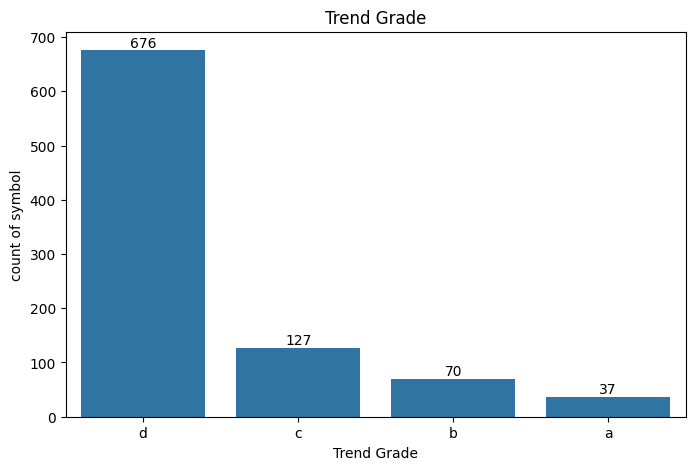

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
ax = sns.countplot(data=df_result, x="trend_grade", order=df_result["trend_grade"].value_counts().index)

plt.title("Trend Grade")
plt.xlabel("Trend Grade")
plt.ylabel("count of symbol")

# ✅ ใส่ตัวเลขบนแท่ง
for p in ax.patches:
    ax.annotate(
        str(int(p.get_height())), 
        (p.get_x() + p.get_width() / 2., p.get_height()), 
        ha='center', va='bottom', fontsize=10
    )

plt.show()


เเบ่งกลุ่มของข้อมูลปัจจัยของหุ้น

เพิ่มคอลัมท์ marketcap

In [25]:
# ✅ 1) ดึงแท่งล่าสุดของแต่ละ symbol
df_latest_candle = (
    df_cand.sort_values("time")
    .groupby("symbol", as_index=False)
    .tail(1)  # หรือใช้ .last() ก็ได้หลัง sort แล้ว
)

# ✅ 2) Merge กับข้อมูล fundamental
df = pd.merge(df_fun, df_latest_candle, on="symbol", how="inner")

# ✅ 3) คำนวณ marketcap
df["marketcap"] = df["close_price"] * df["volume"]

In [26]:
df.head(10)

,symbol,eps,pe,pbv,percentyield,time,close_price,high_price,low_price,open_price,value,volume,marketcap
0,PPPM,0.02000,0.00,0.70,0.00,2025-05-28,0.49,0.51,0.48,0.49,0.0,313650,153688.502991
1,TPCH,0.24112,7.90,0.34,13.91,2025-05-28,3.08,3.10,3.04,3.10,0.0,52708,162340.635979
2,POLY,0.27632,12.89,2.42,6.38,2025-05-28,6.95,6.95,6.65,6.90,0.0,5100,35444.999027
3,VCOM,0.21428,7.85,1.48,10.79,2025-05-28,2.50,2.62,2.50,2.56,0.0,335100,837750.000000
4,KDH,4.12186,10.62,1.93,3.01,2025-05-22,85.00,85.00,84.75,85.00,0.0,1200,102000.000000
5,NVD,-0.00942,38.87,0.32,0.00,2025-05-28,1.00,1.02,1.00,1.02,0.0,16301,16301.000000
6,JDF,0.04224,12.19,1.35,4.85,2025-05-28,1.84,1.85,1.84,1.85,0.0,200,368.000007
7,SVR,-0.03402,0.00,0.34,0.00,2025-05-28,0.58,0.59,0.57,0.58,0.0,47400,27491.999209
8,SUSCO,0.11000,8.75,0.55,8.37,2025-05-28,2.74,2.74,2.70,2.70,0.0,152516,417893.841455
9,STP,0.92828,6.74,1.37,5.60,2025-05-28,9.80,9.90,9.70,9.70,0.0,7600,74480.001450


In [27]:
df.shape

(837, 13)

In [28]:
df.isnull().sum()

symbol          0
eps             0
pe              0
pbv             0
percentyield    0
time            0
close_price     0
high_price      0
low_price       0
open_price      0
value           0
volume          0
marketcap       0
dtype: int64

In [29]:
df.columns

Index(['symbol', 'eps', 'pe', 'pbv', 'percentyield', 'time', 'close_price',
       'high_price', 'low_price', 'open_price', 'value', 'volume',
       'marketcap'],
      dtype='object')

In [30]:
df_fun2 = df.drop(columns=['time',
       'close_price', 'high_price', 'low_price', 'open_price', 'value'])

# 📊 การแบ่งกลุ่มหุ้นตามปัจจัยพื้นฐาน (Fundamental Group)

การจัดกลุ่มหุ้นด้วยปัจจัยพื้นฐาน (Fundamental) ใช้ตัวชี้วัดทางการเงินหลัก 5 ตัว ได้แก่:

* **EPS (Earnings Per Share)** → กำไรต่อหุ้น ยิ่งสูงยิ่งดี
* **PE (Price-to-Earnings Ratio)** → ราคาหุ้นเทียบกับกำไร ยิ่งต่ำยิ่งดี
* **PBV (Price-to-Book Value Ratio)** → ราคาหุ้นเทียบกับมูลค่าทางบัญชี แสดงระดับการประเมินมูลค่า
* **Percent Yield (Dividend Yield)** → อัตราผลตอบแทนจากเงินปันผล (%) ยิ่งสูงยิ่งดี
* **Market Cap (Market Capitalization)** → มูลค่าตลาด ยิ่งสูงยิ่งมั่นคง

---

## 🔎 ขั้นตอนการคำนวณ

1. **เลือกข้อมูลพื้นฐาน (Features)**
   นำค่า `eps, pe, pbv, percentyield, marketcap` ของหุ้นแต่ละตัวมาใช้

2. **ทำการ Standardization (Z-score Normalization)**
   แปลงค่าแต่ละ feature ให้อยู่ในสเกลเดียวกัน (ค่าเฉลี่ย = 0, ส่วนเบี่ยงเบนมาตรฐาน = 1) เพื่อไม่ให้ค่าที่มีขนาดใหญ่ เช่น Market Cap ไปครอบงำค่าคะแนนรวม

3. **สร้างคะแนนรวม (Score)**
   รวมค่าที่ผ่านการปรับสเกลแล้วเป็นคะแนนเดียว

   * `+ EPS` → EPS สูง ดี
   * `- PE` → PE ต่ำ ดี
   * `+ PBV` → PBV สูง (สะท้อนการเติบโต)
   * `+ Dividend Yield` → ปันผลสูง ดี
   * `+ Market Cap` → บริษัทใหญ่มั่นคง

   สูตรคะแนนรวม:

   ```
   Score = (EPS_scaled) - (PE_scaled) + (PBV_scaled) + (Yield_scaled) + (MarketCap_scaled)
   ```

4. **แบ่งออกเป็น 5 กลุ่มด้วย Quantile (qcut)**

   * A = Top 20% (พื้นฐานแข็งแกร่งที่สุด)
   * B = 20–40% (พื้นฐานดี)
   * C = 40–60% (พื้นฐานปานกลาง)
   * D = 60–80% (พื้นฐานอ่อน)
   * E = Bottom 20% (พื้นฐานอ่อนที่สุด)

---

## 🏷 การตีความ

* **A** → หุ้นที่มีปัจจัยพื้นฐานดีที่สุด เหมาะกับการลงทุนระยะยาว
* **B** → หุ้นพื้นฐานดี มีศักยภาพในการเติบโต
* **C** → หุ้นพื้นฐานปานกลาง ความเสี่ยง/โอกาสสมดุล
* **D** → หุ้นพื้นฐานอ่อน เสี่ยงสูงขึ้น
* **E** → หุ้นพื้นฐานอ่อนที่สุด ควรหลีกเลี่ยง


In [31]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# ✅ เลือก features
features = ['eps', 'pe', 'pbv', 'percentyield', 'marketcap']
X = df_fun2[features].dropna().copy()

# ✅ Standardization (Z-score)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=features, index=X.index)

# ✅ สร้างคะแนนรวม (ปรับเครื่องหมายตาม logic)
X_scaled_df['score'] = (
    X_scaled_df['eps'] - X_scaled_df['pe'] +
    X_scaled_df['pbv'] + X_scaled_df['percentyield'] +
    X_scaled_df['marketcap']
)

# ✅ แบ่งออกเป็น 5 กลุ่มตาม quantile แล้วใช้ label = ['a','b','c','d','e']
df_fun2.loc[X.index, 'stat_group'] = pd.qcut(
    X_scaled_df['score'],
    5,
    labels=['A','B','C','D','E']
)

# ✅ ดูผลลัพธ์
print(df_fun2[['symbol','eps','pe','pbv','percentyield','marketcap','stat_group']].head())


  symbol      eps     pe   pbv  percentyield      marketcap stat_group
0   PPPM  0.02000   0.00  0.70          0.00  153688.502991          B
1   TPCH  0.24112   7.90  0.34         13.91  162340.635979          E
2   POLY  0.27632  12.89  2.42          6.38   35444.999027          E
3   VCOM  0.21428   7.85  1.48         10.79  837750.000000          E
4    KDH  4.12186  10.62  1.93          3.01  102000.000000          E


In [32]:
df_fun2.head(10)

,symbol,eps,pe,pbv,percentyield,volume,marketcap,stat_group
0,PPPM,0.02000,0.00,0.70,0.00,313650,153688.502991,B
1,TPCH,0.24112,7.90,0.34,13.91,52708,162340.635979,E
2,POLY,0.27632,12.89,2.42,6.38,5100,35444.999027,E
3,VCOM,0.21428,7.85,1.48,10.79,335100,837750.000000,E
4,KDH,4.12186,10.62,1.93,3.01,1200,102000.000000,E
5,NVD,-0.00942,38.87,0.32,0.00,16301,16301.000000,A
6,JDF,0.04224,12.19,1.35,4.85,200,368.000007,C
7,SVR,-0.03402,0.00,0.34,0.00,47400,27491.999209,A
8,SUSCO,0.11000,8.75,0.55,8.37,152516,417893.841455,D
9,STP,0.92828,6.74,1.37,5.60,7600,74480.001450,D


In [33]:
df['quadrant'] = df_fun2['stat_group'].astype(str) + df_result['trend_grade'].astype(str)


In [34]:
df.head(10) 

,symbol,eps,pe,pbv,percentyield,time,close_price,high_price,low_price,open_price,value,volume,marketcap,quadrant
0,PPPM,0.02000,0.00,0.70,0.00,2025-05-28,0.49,0.51,0.48,0.49,0.0,313650,153688.502991,Bd
1,TPCH,0.24112,7.90,0.34,13.91,2025-05-28,3.08,3.10,3.04,3.10,0.0,52708,162340.635979,Ec
2,POLY,0.27632,12.89,2.42,6.38,2025-05-28,6.95,6.95,6.65,6.90,0.0,5100,35444.999027,Eb
3,VCOM,0.21428,7.85,1.48,10.79,2025-05-28,2.50,2.62,2.50,2.56,0.0,335100,837750.000000,Ed
4,KDH,4.12186,10.62,1.93,3.01,2025-05-22,85.00,85.00,84.75,85.00,0.0,1200,102000.000000,Ed
5,NVD,-0.00942,38.87,0.32,0.00,2025-05-28,1.00,1.02,1.00,1.02,0.0,16301,16301.000000,Ad
6,JDF,0.04224,12.19,1.35,4.85,2025-05-28,1.84,1.85,1.84,1.85,0.0,200,368.000007,Cd
7,SVR,-0.03402,0.00,0.34,0.00,2025-05-28,0.58,0.59,0.57,0.58,0.0,47400,27491.999209,Ad
8,SUSCO,0.11000,8.75,0.55,8.37,2025-05-28,2.74,2.74,2.70,2.70,0.0,152516,417893.841455,Dd
9,STP,0.92828,6.74,1.37,5.60,2025-05-28,9.80,9.90,9.70,9.70,0.0,7600,74480.001450,Dd


In [35]:
import plotly.graph_objects as go
df_result3=df
# ✅ จัดกลุ่มหุ้นตาม quadrant
quadrant_groups = df_result3.groupby('quadrant')['symbol'].apply(list).to_dict()

# ✅ กำหนดลำดับของแกน
financial_levels = ['A', 'B', 'C', 'D', 'E']  # A = Strong fundamentals
trend_levels = ['a', 'b', 'c', 'd', 'e']      # a = Bullish, e = Crash

# ✅ เตรียมข้อมูลแต่ละเซลล์ในตาราง (5x5)
plot_table = []
for f in financial_levels:
    row = []
    for t in trend_levels:
        code = f + t
        stocks = quadrant_groups.get(code, [])
        if stocks:
            stock_list = "<br>".join(stocks[:10])  # แสดงสูงสุด 10 ตัว
            cell_text = f"<b>{code}</b><br>{stock_list}"
        else:
            cell_text = f"<b>{code}</b><br>-"
        row.append(cell_text)
    plot_table.append(row)

# ✅ สร้างสีของแต่ละแถวตามกลุ่มพื้นฐาน A–E
colors = [[{'A': '#2ecc71', 'B': '#58d68d', 'C': '#f4d03f', 'D': '#f39c12', 'E': '#e74c3c'}[f]]*5 for f in financial_levels]

# ✅ Plotly Table
fig = go.Figure(data=go.Table(
    header=dict(
        fill_color="#dcdcdc",
        align="center",
        font=dict(color="black", size=14)
    ),
    cells=dict(
        values=plot_table,
        fill_color=colors,
        align="center",
        height=100,
        font=dict(color="white", size=12)
    )
))

# ✅ ตั้งชื่อกราฟ
fig.update_layout(title="📊 Stock Quadrant Table (Aa–Ee) จาก Rule-Based or Model")
fig.show()


In [36]:
import plotly.express as px
quadrant_counts = df_result3['quadrant'].value_counts().sort_index()
financial_levels = ["A","B","C","D","E"]   # กลุ่มพื้นฐาน (Fundamental)
trend_levels = ["a","b","c","d","e"]       # กลุ่มเทคนิค (Trend)

heatmap_data = pd.DataFrame(0, index=financial_levels, columns=trend_levels)
for q, count in quadrant_counts.items():
    fin = q[0]   # เช่น "A"
    trend = q[1] # เช่น "a"
    heatmap_data.loc[fin, trend] = count
fig = px.imshow(
    heatmap_data,
    labels=dict(x="Trend (a–e)", y="Fundamental Group (A–E)", color="Stock Count"),
    x=trend_levels,
    y=financial_levels,
    color_continuous_scale="YlOrRd",
    text_auto=True
)
fig.update_layout(title="📊 Quadrant Heatmap (Predicted by ANN)")

In [37]:
df.columns

Index(['symbol', 'eps', 'pe', 'pbv', 'percentyield', 'time', 'close_price',
       'high_price', 'low_price', 'open_price', 'value', 'volume', 'marketcap',
       'quadrant'],
      dtype='object')

In [38]:
df.shape

(837, 14)

Modelling

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [40]:
# -----------------------------
# 1. เตรียมข้อมูล
# -----------------------------
features = ['eps', 'pe', 'pbv', 'percentyield', 'time', 'close_price',
            'high_price', 'low_price', 'open_price', 'value', 'marketcap']

X = df[features].dropna().copy()
X = X.select_dtypes(include=["float64", "int64"])  # เอาเฉพาะ numeric
y = df.loc[X.index, 'quadrant']

# Encode target
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_categorical, test_size=0.2, random_state=42
)

# -----------------------------
# 2. ฟังก์ชันสร้างโมเดล
# -----------------------------
def create_model(input_dim, output_dim):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(output_dim, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# -----------------------------
# 3. Train หลายรอบหา Best Model
# -----------------------------
target_acc = 0.85
best_model, best_acc, best_history = None, 0, None

for i in range(100):  # เทรนใหม่สูงสุด 10 รอบ
    print(f"\n🔄 Training round {i+1}")
    model = create_model(X_train.shape[1], y_categorical.shape[1])
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=50,
        batch_size=32,
        verbose=0
    )
    
    _, acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"✅ Accuracy = {acc:.2%}")
    
    if acc > best_acc:
        best_acc = acc
        best_model = model
        best_history = history
    
    if acc >= target_acc:
        print("🎯 Target reached! Stop training.")
        break


🔄 Training round 1


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



✅ Accuracy = 74.40%

🔄 Training round 2
✅ Accuracy = 70.83%

🔄 Training round 3
✅ Accuracy = 72.62%

🔄 Training round 4
✅ Accuracy = 72.62%

🔄 Training round 5
✅ Accuracy = 73.21%

🔄 Training round 6
✅ Accuracy = 71.43%

🔄 Training round 7
✅ Accuracy = 72.62%

🔄 Training round 8
✅ Accuracy = 72.02%

🔄 Training round 9
✅ Accuracy = 72.62%

🔄 Training round 10
✅ Accuracy = 72.02%

🔄 Training round 11
✅ Accuracy = 72.02%

🔄 Training round 12
✅ Accuracy = 72.62%

🔄 Training round 13
✅ Accuracy = 72.62%

🔄 Training round 14
✅ Accuracy = 73.81%

🔄 Training round 15
✅ Accuracy = 71.43%

🔄 Training round 16
✅ Accuracy = 73.21%

🔄 Training round 17
✅ Accuracy = 72.62%

🔄 Training round 18
✅ Accuracy = 71.43%

🔄 Training round 19
✅ Accuracy = 72.62%

🔄 Training round 20
✅ Accuracy = 72.62%

🔄 Training round 21
✅ Accuracy = 70.24%

🔄 Training round 22
✅ Accuracy = 72.62%

🔄 Training round 23
✅ Accuracy = 73.81%

🔄 Training round 24
✅ Accuracy = 73.21%

🔄 Training round 25
✅ Accuracy = 73.21%

🔄 T

ผลลัพท์ที่ดีที่สุดจากรันโมเดล100รอบ

In [41]:
print(f"\nBest Accuracy = {best_acc:.2%}")


Best Accuracy = 75.00%


In [42]:
# -----------------------------
# ใช้ best_model ที่เทรนมาแล้ว
# -----------------------------

# ทำนายทั้งหมด
y_all_pred = best_model.predict(X_scaled)
y_all_classes = np.argmax(y_all_pred, axis=1)

# แปลงกลับเป็น label Quadrant
y_all_labels = le.inverse_transform(y_all_classes)

# ตารางผลลัพธ์ทั้งหมด
df_all_results = pd.DataFrame({
    "Symbol": df.loc[X.index, "symbol"],
    "True Quadrant": le.inverse_transform(y_encoded),
    "Predicted Quadrant": y_all_labels
})

df_all_results.head(20)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


,Symbol,True Quadrant,Predicted Quadrant
0,PPPM,Bd,Bd
1,TPCH,Ec,Ed
2,POLY,Eb,Ed
3,VCOM,Ed,Ed
4,KDH,Ed,Ed
5,NVD,Ad,Ad
6,JDF,Cd,Cd
7,SVR,Ad,Ad
8,SUSCO,Dd,Dd
9,STP,Dd,Dd


In [43]:
df_all_results.shape

(837, 3)

In [44]:
from sklearn.metrics import accuracy_score

# Accuracy บนข้อมูลทั้งหมด
all_acc = accuracy_score(
    le.inverse_transform(y_encoded),   # ค่าจริง
    y_all_labels                       # ค่าที่โมเดลทำนาย
)

print(f"📌 Accuracy on All Data = {all_acc:.2%}")

📌 Accuracy on All Data = 73.00%


In [45]:
import plotly.express as px
quadrant_counts = df_all_results["Predicted Quadrant"].value_counts().sort_index()
financial_levels = ["A","B","C","D","E"]   # กลุ่มพื้นฐาน (Fundamental)
trend_levels = ["a","b","c","d","e"]       # กลุ่มเทคนิค (Trend)

heatmap_data = pd.DataFrame(0, index=financial_levels, columns=trend_levels)
for q, count in quadrant_counts.items():
    fin = q[0]   # เช่น "A"
    trend = q[1] # เช่น "a"
    heatmap_data.loc[fin, trend] = count
fig = px.imshow(
    heatmap_data,
    labels=dict(x="Trend (a–e)", y="Fundamental Group (A–E)", color="Stock Count"),
    x=trend_levels,
    y=financial_levels,
    color_continuous_scale="YlOrRd",
    text_auto=True
)
fig.update_layout(title="📊 Quadrant Heatmap (Predicted by ANN)")


In [49]:
import plotly.graph_objects as go

# ✅ สร้าง dict: Quadrant → รายชื่อหุ้น
quadrant_groups = (
    df_all_results.groupby("Predicted Quadrant")["Symbol"]
    .apply(list)
    .to_dict()
)

# ✅ กำหนดลำดับแกน
financial_levels = ['A', 'B', 'C', 'D', 'E']  # A = Strong fundamentals
trend_levels = ['a', 'b', 'c', 'd', 'e']      # a = Bullish, e = Crash

# ✅ เตรียมตาราง 5x5
plot_table = []
for f in financial_levels:
    row = []
    for t in trend_levels:
        code = f + t
        stocks = quadrant_groups.get(code, [])
        if stocks:
            stock_list = "<br>".join(stocks[:10])  # แสดงสูงสุด 10 ตัว
            cell_text = f"<b>{code}</b><br>{stock_list}"
        else:
            cell_text = f"<b>{code}</b><br>-"
        row.append(cell_text)
    plot_table.append(row)

# ✅ สีแต่ละแถว (A–E)
colors = [[{'A': '#2ecc71', 'B': '#58d68d', 'C': '#f4d03f',
            'D': '#f39c12', 'E': '#e74c3c'}[f]]*5 for f in financial_levels]

# ✅ วาดตาราง
fig = go.Figure(data=go.Table(
    header=dict(
        values=["Super Bullish (a)", "Up Trend (b)", "Sideway (c)", "Down Trend (d)", "Crash (e)"],
        fill_color="#dcdcdc",
        align="center",
        font=dict(color="black", size=14)
    ),
    cells=dict(
        values=plot_table,
        fill_color=colors,
        align="center",
        height=100,
        font=dict(color="white", size=12)
    )
))

fig.update_layout(title="📊 Stock Quadrant Table จาก df_all_results (Predicted)")
fig.show()


RULE-BASE

In [55]:
import pandas as pd
import numpy as np
import ta
from sklearn.preprocessing import StandardScaler

# -------------------------------
# 1) ฟังก์ชันคำนวณ Technical Grade (a–e)
# -------------------------------
def compute_technical_grades(df_candle, band_pct=0.015):
    df_result = []

    for symbol, df_sym in df_candle.groupby('symbol'):
        df_sym = df_sym.sort_values('time').copy()
        df_sym = df_sym.dropna(subset=['close_price'])

        if len(df_sym) < 50:
            continue

        # EMA + RSI
        df_sym['ema5']   = df_sym['close_price'].ewm(span=5).mean()
        df_sym['ema15']  = df_sym['close_price'].ewm(span=15).mean()
        df_sym['ema35']  = df_sym['close_price'].ewm(span=35).mean()
        df_sym['ema89']  = df_sym['close_price'].ewm(span=89).mean()
        df_sym['ema200'] = df_sym['close_price'].ewm(span=200).mean()
        df_sym['rsi']    = ta.momentum.RSIIndicator(close=df_sym['close_price'], window=14).rsi()

        df_sym = df_sym.dropna(subset=['ema5','ema15','ema35','ema89','ema200','rsi'])
        if df_sym.empty:
            continue

        # ใช้ข้อมูลล่าสุด
        row = df_sym.iloc[-1]
        c, r = row['close_price'], row['rsi']
        e5, e15, e35, e89, e200 = row['ema5'], row['ema15'], row['ema35'], row['ema89'], row['ema200']

        # Rule-based grading
        if c >= e5 and r >= 70:
            grade = 'a'
        elif c >= e35 and e35 >= e89:
            grade = 'b'
        elif c >= e89 and (max([e5,e15,e35,e89]) - min([e5,e15,e35,e89])) / np.mean([e5,e15,e35,e89]) <= band_pct:
            grade = 'c'
        elif c < e89 and c < e200 and e89 < e200:
            grade = 'd'
        elif c < e5 < e15 < e35 < e89 < e200 and r <= 30:
            grade = 'e'
        else:
            grade = 'c'

        df_result.append({
            'symbol': symbol,
            'trend_grade': grade
        })

    return pd.DataFrame(df_result)


# -------------------------------
# 2) ฟังก์ชันคำนวณ Fundamental Group (A–E)
# -------------------------------
def compute_fundamental_groups(df_fun):
    features = ['eps', 'pe', 'pbv', 'percentyield', 'marketcap']
    X = df_fun[features].dropna().copy()

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled_df = pd.DataFrame(X_scaled, columns=features, index=X.index)

    # สร้างคะแนนรวม (คุณอาจปรับ logic ได้)
    X_scaled_df['score'] = (
        X_scaled_df['eps'] - X_scaled_df['pe'] +
        X_scaled_df['pbv'] + X_scaled_df['percentyield'] +
        X_scaled_df['marketcap']
    )

    df_fun.loc[X.index, 'stat_group'] = pd.qcut(
        X_scaled_df['score'], 5, labels=['A','B','C','D','E']
    )

    return df_fun[['symbol','stat_group']]


# -------------------------------
# 3) รวมสองผลลัพธ์ → Quadrant (Aa–Ee)
# -------------------------------
def compute_quadrant(df_fun, df_candle):
    df_fundamental = compute_fundamental_groups(df_fun)
    df_technical   = compute_technical_grades(df_candle)

    df_merge = pd.merge(df_fundamental, df_technical, on='symbol', how='inner')
    
    # ✅ fix type error
    df_merge['quadrant'] = df_merge['stat_group'].astype(str) + df_merge['trend_grade'].astype(str)
    return df_merge


In [56]:
# -------------------------------
# ✅ ใช้งาน
# -------------------------------
df_quadrant = compute_quadrant(df_fun2, df_cand)

print(df_quadrant.head())

  symbol stat_group trend_grade quadrant
0   PPPM          B           c       Bc
1   TPCH          E           d       Ed
2   POLY          E           d       Ed
3   VCOM          E           c       Ec
4    KDH          E           d       Ed
